# **NN (NEURAL NETWORK)**

Bu çalışmada elektrikli araç veri seti kullanılarak **neural network (yapay sinir ağı)** tabanlı bir regresyon modeli geliştirilmiştir. Modelin hedef değişkeni `soc_net_per_s_smooth5` olup, bu değer batarya şarj durumunun (State of Charge – SOC) zamana göre değişim hızını temsil etmektedir. Modelin amacı, mevcut sensör verileri ve sürüş parametrelerini kullanarak SOC değişimini olabildiğince doğru tahmin etmektir.

Yöntem olarak **Multi-Layer Perceptron (MLP)** mimarisi tercih edilmiştir. MLP, tam bağlantılı katmanlardan oluşan temel bir yapay sinir ağıdır ve özellikle tabular veriler üzerinde başarılı sonuçlar vermektedir. Modelde birden fazla gizli katman, **aktivasyon fonksiyonları (ReLU/GELU)**, **Batch Normalization** ve **Dropout** kullanılmıştır. Bu sayede model hem karmaşık doğrusal olmayan ilişkileri öğrenebilmekte hem de aşırı öğrenmeye (overfitting) karşı dayanıklı hale gelmektedir.

Veri ön işleme aşamasında, özellikler ve hedef değişken **standardize edilmiş**, veri seti ise **Experiment_ID** sütunu dikkate alınarak grup-bilinçli şekilde Train, Validation ve Test kümelerine ayrılmıştır. Eğitimde **SmoothL1 (Huber) kaybı**, **Adam/AdamW optimizasyonu**, **öğrenme oranı planlayıcıları** ve **erken durdurma** teknikleri kullanılmıştır. Değerlendirmede hem genel (MAE, RMSE, R²) hem de her bir deney grubuna özel performans metrikleri hesaplanmıştır.

Bu yaklaşım, elektrikli araçlarda enerji tüketimi ve batarya yönetimiyle ilgili öngörülerin doğruluğunu artırarak, daha verimli sürüş stratejilerinin ve enerji optimizasyonunun önünü açmaktadır.


## **1 – Kurulum & Kütüphaneler**

Bu bölümde gerekli Python kütüphaneleri yüklenir ve içe aktarılır.  
- **pandas, numpy**: veri işleme  
- **scikit-learn**: veri ön işleme, metrikler, grup bazlı bölme  
- **PyTorch**: neural network modeli  

In [1]:
import os
import math
import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from google.colab import files
uploaded = files.upload()
import pandas as pd
df = pd.read_csv("ev_dataset_multi_target.csv")

Saving ev_dataset_multi_target.csv to ev_dataset_multi_target (3).csv


## **2 – Ayarlar**

Modelin temel hiperparametreleri tanımlanır:  
- Dosya yolları ve hedef/grup sütunları  
- Train/Val/Test oranları  
- Batch size, öğrenme oranı, epoch, patience  
- Neural network mimarisi (katman boyutları, dropout)  
- GPU/CPU cihaz seçimi  

In [2]:
CANDIDATE_PATHS = [
    "ev_dataset_multi_target.csv",
]
TARGET_COL   = "soc_net_per_s_smooth5"
GROUP_CANDIDATES = ["Experiment_ID"]

TEST_SIZE    = 0.15
VAL_SIZE     = 0.15
RANDOM_STATE = 42

BATCH_SIZE   = 256
LR           = 3e-3
MAX_EPOCHS   = 200
PATIENCE     = 20

HIDDEN_SIZES = [512, 256, 128]
DROPOUTS     = [0.15, 0.10, 0.05]

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## **3 – Yardımcı Fonksiyonlar**

Eğitim süresince kullanılacak fonksiyonlar:  
- RMSE ve skor hesaplama fonksiyonları  
- Grup bazlı metrik çıkartıcı (her experiment için MAE, RMSE, R²)  

In [3]:

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def describe_scores(y_true, y_pred, prefix=""):
    return {
        f"{prefix}MAE": float(mean_absolute_error(y_true, y_pred)),
        f"{prefix}RMSE": float(rmse(y_true, y_pred)),
        f"{prefix}R2": float(r2_score(y_true, y_pred))
    }

def group_scores(df_eval, group_col, y_col, yhat_col):
    rows = []
    for gid, g in df_eval.groupby(group_col):
        rows.append({
            group_col: gid,
            "MAE": mean_absolute_error(g[y_col], g[yhat_col]),
            "RMSE": rmse(g[y_col], g[yhat_col]),
            "R2": r2_score(g[y_col], g[yhat_col]) if len(g) > 1 else np.nan,
        })
    return pd.DataFrame(rows).sort_values("MAE")


## **4 – Veri Yükleme & Hazırlık**

Veri CSV dosyasından okunur.  
- Hedef (y) ve grup sütunu doğrulanır.  
- Sayısal özellikler seçilir.  
- Eksik değerler medyan ile doldurulur.  
- X (özellikler), y (hedef), group (deney kimliği) hazırlanır.

In [4]:
CSV_PATH = CANDIDATE_PATHS[0]
df = pd.read_csv(CSV_PATH)

if TARGET_COL not in df.columns:
    raise ValueError(f"Hedef '{TARGET_COL}' yok. Sütunlar: {list(df.columns)}")

GROUP_COL = GROUP_CANDIDATES[0]

# Sayısal özellikleri seçildi
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c not in [TARGET_COL] and c != GROUP_COL]

# Eksik değer temizliği
df = df.dropna(subset=[TARGET_COL]).copy()
df[feature_cols] = df[feature_cols].fillna(df[feature_cols].median())

X_all = df[feature_cols].values.astype(np.float32)
y_all = df[TARGET_COL].values.astype(np.float32).reshape(-1, 1)
groups_all = df[GROUP_COL].values


## **5 – Train / Validation / Test Bölme**

Veri **GroupShuffleSplit** ile 3 parçaya ayrılır:  
- Train, Validation, Test setleri  
- Aynı `experiment_id` sadece tek sette yer alır → veri sızıntısı önlenir.

In [5]:
gss = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
idx_tr, idx_te = next(gss.split(X_all, y_all, groups_all))

X_trval, y_trval, groups_trval = X_all[idx_tr], y_all[idx_tr], groups_all[idx_tr]
X_te,    y_te,    groups_te    = X_all[idx_te], y_all[idx_te], groups_all[idx_te]

gss2 = GroupShuffleSplit(n_splits=1, test_size=VAL_SIZE/(1-TEST_SIZE), random_state=RANDOM_STATE)
idx_tr2, idx_val = next(gss2.split(X_trval, y_trval, groups_trval))

X_tr, y_tr = X_trval[idx_tr2], y_trval[idx_tr2]
X_val, y_val = X_trval[idx_val], y_trval[idx_val]

print(f"Feature sayısı: {X_tr.shape[1]}")
print(f"Train/Val/Test: {len(X_tr)} / {len(X_val)} / {len(X_te)}")


Feature sayısı: 16
Train/Val/Test: 10224 / 2274 / 2159


## **6 – Ölçekleme**

- Özellikler (X) ve hedef (y) **StandardScaler** ile standardize edilir.  
- Böylece farklı ölçeklerdeki değişkenler NN eğitimini bozmaz.  
- Torch tensörleri hazırlanır ve DataLoader ile paketlenir.

In [6]:
x_scaler = StandardScaler()
X_tr_s = x_scaler.fit_transform(X_tr)
X_val_s = x_scaler.transform(X_val)
X_te_s  = x_scaler.transform(X_te)

y_scaler = StandardScaler()
y_tr_s   = y_scaler.fit_transform(y_tr)
y_val_s  = y_scaler.transform(y_val)
y_te_s   = y_scaler.transform(y_te)

# Torch tensörleri
Xtr_t  = torch.tensor(X_tr_s, dtype=torch.float32)
ytr_t  = torch.tensor(y_tr_s, dtype=torch.float32)
Xval_t = torch.tensor(X_val_s, dtype=torch.float32)
yval_t = torch.tensor(y_val_s, dtype=torch.float32)
Xte_t  = torch.tensor(X_te_s,  dtype=torch.float32)
yte_t  = torch.tensor(y_te_s,  dtype=torch.float32)

train_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(TensorDataset(Xval_t, yval_t), batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(TensorDataset(Xte_t, yte_t),   batch_size=BATCH_SIZE, shuffle=False)


## **7 – Model Tanımı**

Model: **MLP (Multi-Layer Perceptron)**  
- 3 gizli katman (512 → 256 → 128 nöron)  
- ReLU aktivasyon  
- Batch Normalization + Dropout  
- Çıkış katmanı: 1 nöron (regresyon)  

In [7]:
class MLPRegressor(nn.Module):
    def __init__(self, in_dim, hidden_sizes, dropouts):
        super().__init__()
        layers = []
        prev = in_dim
        for h, d in zip(hidden_sizes, dropouts):
            layers += [
                nn.Linear(prev, h),
                nn.ReLU(),
                nn.BatchNorm1d(h),
                nn.Dropout(d),
            ]
            prev = h
        layers += [nn.Linear(prev, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

input_dim = Xtr_t.shape[1]
model = MLPRegressor(input_dim, HIDDEN_SIZES, DROPOUTS).to(DEVICE)

criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5
)


## **8 – Eğitim Döngüsü**

- Kayıp fonksiyonu: **SmoothL1Loss (Huber)**  
- Optimizasyon: **Adam + Weight Decay**  
- LR Scheduler: **ReduceLROnPlateau**  
- Erken durdurma uygulanır.  
- Gradient clipping ile patlayan değerler engellenir.  

In [8]:
def eval_loader_scaled(loader):
    model.eval()
    ys, yhats = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE)
            out = model(xb)
            ys.append(yb.cpu().numpy())
            yhats.append(out.cpu().numpy())
    return np.concatenate(ys,0), np.concatenate(yhats,0)

best_val_mae = float("inf"); best_state=None; no_improve=0

for epoch in range(1, MAX_EPOCHS+1):
    model.train(); train_losses=[]
    for xb,yb in train_loader:
        xb=xb.to(DEVICE); yb=yb.to(DEVICE)
        optimizer.zero_grad()
        out=model(xb); loss=criterion(out,yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        train_losses.append(loss.item())

    y_val_true_s,y_val_pred_s=eval_loader_scaled(val_loader)
    y_val_true=y_scaler.inverse_transform(y_val_true_s)
    y_val_pred=y_scaler.inverse_transform(y_val_pred_s)
    val_mae=mean_absolute_error(y_val_true,y_val_pred)
    val_rmse=rmse(y_val_true,y_val_pred)
    scheduler.step(val_mae)

    if val_mae<best_val_mae-1e-12:
        best_val_mae=val_mae
        best_state={
            "model":model.state_dict(),
            "x_mean":x_scaler.mean_.tolist(),
            "x_scale":x_scaler.scale_.tolist(),
            "y_mean":float(y_scaler.mean_[0]),
            "y_scale":float(y_scaler.scale_[0]),
            "feature_cols":feature_cols}
        no_improve=0
    else:
        no_improve+=1

    if epoch%5==0 or epoch==1:
        print(f"Epoch {epoch:03d} | train loss: {np.mean(train_losses):.6f} | val MAE: {val_mae:.6f} | val RMSE: {val_rmse:.6f}")
    if no_improve>=PATIENCE:
        print(f"Erken durdurma (patience={PATIENCE}) en iyi val MAE: {best_val_mae:.6f}")
        break

if best_state: model.load_state_dict(best_state["model"])


Epoch 001 | train loss: 0.103923 | val MAE: 0.001104 | val RMSE: 0.001436
Epoch 005 | train loss: 0.043919 | val MAE: 0.001066 | val RMSE: 0.001394
Epoch 010 | train loss: 0.040903 | val MAE: 0.001124 | val RMSE: 0.001456
Epoch 015 | train loss: 0.037489 | val MAE: 0.001043 | val RMSE: 0.001369
Epoch 020 | train loss: 0.037076 | val MAE: 0.001064 | val RMSE: 0.001387
Epoch 025 | train loss: 0.034832 | val MAE: 0.001106 | val RMSE: 0.001449
Epoch 030 | train loss: 0.032958 | val MAE: 0.001124 | val RMSE: 0.001476
Epoch 035 | train loss: 0.031357 | val MAE: 0.001041 | val RMSE: 0.001361
Epoch 040 | train loss: 0.031891 | val MAE: 0.001058 | val RMSE: 0.001377
Epoch 045 | train loss: 0.030064 | val MAE: 0.001066 | val RMSE: 0.001389
Epoch 050 | train loss: 0.029183 | val MAE: 0.001055 | val RMSE: 0.001378
Epoch 055 | train loss: 0.027196 | val MAE: 0.001048 | val RMSE: 0.001370
Erken durdurma (patience=20) en iyi val MAE: 0.001041


## **9 – Değerlendirme**

- Train, Validation, Test setlerinde model tahminleri alınır.  
- Tahminler inverse transform edilerek orijinal ölçeğe döndürülür.  
- Genel metrikler hesaplanır: MAE, RMSE, R².  

In [9]:
# scaled pred alındı
y_tr_true_s,y_tr_pred_s=eval_loader_scaled(train_loader)
y_val_true_s,y_val_pred_s=eval_loader_scaled(val_loader)
y_te_true_s,y_te_pred_s=eval_loader_scaled(test_loader)

# orijinal ölçeğe dönüldü
y_tr_true=y_scaler.inverse_transform(y_tr_true_s)
y_tr_pred=y_scaler.inverse_transform(y_tr_pred_s)
y_val_true=y_scaler.inverse_transform(y_val_true_s)
y_val_pred=y_scaler.inverse_transform(y_val_pred_s)
y_te_true=y_scaler.inverse_transform(y_te_true_s)
y_te_pred=y_scaler.inverse_transform(y_te_pred_s)

print("\n== Genel Skorlar ==")
print(describe_scores(y_tr_true,y_tr_pred,"Train_"))
print(describe_scores(y_val_true,y_val_pred,"Val_"))
print(describe_scores(y_te_true,y_te_pred,"Test_"))



== Genel Skorlar ==
{'Train_MAE': 0.000688063504640013, 'Train_RMSE': 0.0009343252168036997, 'Train_R2': 0.9586695432662964}
{'Val_MAE': 0.0010478920303285122, 'Val_RMSE': 0.0013701959978789091, 'Val_R2': 0.9250474572181702}
{'Test_MAE': 0.001075215870514512, 'Test_RMSE': 0.0014516771771013737, 'Test_R2': 0.9170486330986023}


## **10 - Menzil**

In [10]:
# Modeli ve skalacıları yükle
input_dim = len(best_state['feature_cols'])
model = MLPRegressor(input_dim, HIDDEN_SIZES, DROPOUTS).to(DEVICE)
model.load_state_dict(best_state["model"])
model.eval()

# Scaler nesnelerini yeniden oluştur ve eğitilen değerlerle doldur
x_scaler = StandardScaler()
x_scaler.mean_ = np.array(best_state['x_mean'])
x_scaler.scale_ = np.array(best_state['x_scale'])

y_scaler = StandardScaler()
y_scaler.mean_ = np.array([best_state['y_mean']])
y_scaler.scale_ = np.array([best_state['y_scale']])

PRED_COL = "y_pred_soc_rate_pps"
feature_cols = best_state["feature_cols"]
usable_kwh_est = 62.7  # kWh

# Veri setini tahmin için hazırla
X_full = df[feature_cols].copy()
X_full = X_full.fillna(df[feature_cols].median())

# Özellikleri ölçekle
X_full_scaled = x_scaler.transform(X_full.values.astype(np.float32))

# NN tahminini yap
preds = []
with torch.no_grad():
    for i in range(0, X_full_scaled.shape[0], 4096):
        xb = torch.tensor(X_full_scaled[i:i+4096], dtype=torch.float32, device=DEVICE)
        out = model(xb).cpu().numpy()
        preds.append(out)

y_scaled = np.vstack(preds)
df[PRED_COL] = y_scaler.inverse_transform(y_scaled).reshape(-1)

print(f"[OK] {PRED_COL} eklendi. Örnek:", np.round(df[PRED_COL].head(3).to_numpy(), 6).tolist())

[OK] y_pred_soc_rate_pps eklendi. Örnek: [0.0020749999675899744, 0.0027179999742656946, 0.0030789999291300774]


In [11]:
# KALAN MENZİL HESAPLAMA (MODEL TABANLI)
rows = []
DEFAULT_DT = 1.0

GROUP_COL = "Experiment_ID"

for exp_id, g in df.groupby(GROUP_COL, sort=False):
    dist_km = 2.0
    pred_energy_kwh_per_s = usable_kwh_est * (g[PRED_COL].to_numpy() / 100.0)
    energy_kwh = float((pred_energy_kwh_per_s * DEFAULT_DT).sum())

    if energy_kwh <= 0 or dist_km <= 0:
        continue

    avg_cons = energy_kwh / dist_km
    soc_end = float(g["SoC"].iloc[-1])
    remaining_kwh = usable_kwh_est * soc_end / 100.0
    remaining_range_km = remaining_kwh / avg_cons

    rows.append({
        GROUP_COL: exp_id,
        "model_avg_cons_kWh_per_km": avg_cons,
        "SoC_end_%": soc_end,
        "remaining_kWh": remaining_kwh,
        "Remaining_Range_km_MODEL": remaining_range_km,
        "model_energy_used_kWh": energy_kwh
    })

exp_remaining_df = pd.DataFrame(rows)

exp_remaining_df = exp_remaining_df.sort_values("Remaining_Range_km_MODEL", ascending=False).reset_index(drop=True)
display(exp_remaining_df.head(20))


,Experiment_ID,model_avg_cons_kWh_per_km,SoC_end_%,remaining_kWh,Remaining_Range_km_MODEL,model_energy_used_kWh
0,Experiment_11,0.264084,65.59,41.12493,155.726887,0.528167
1,Experiment_8,0.280834,68.12,42.71124,152.086953,0.561669
2,Experiment_12,0.275845,64.71,40.57317,147.086863,0.551690
3,Experiment_9,0.288010,67.16,42.10932,146.207703,0.576021
4,Experiment_21,0.332298,69.08,43.31316,130.344150,0.664597
5,Experiment_20,0.353792,70.82,44.40414,125.509250,0.707584
6,Experiment_10,0.305579,51.96,32.57892,106.613769,0.611158
7,Experiment_7,0.332150,47.98,30.08346,90.571923,0.664300
8,Experiment_4,0.442859,60.05,37.65135,85.018742,0.885719
9,Experiment_22,0.393445,52.95,33.19965,84.381956,0.786890


In [12]:
# GERÇEK VS MODEL TABANLI KALAN MENZİL KARŞILAŞTIRMA
rows = []
usable_kwh_est = 62.7

for exp_id, g in df.groupby("Experiment_ID", sort=False):
    # --- Gerçek Değerler ---
    soc_start = float(g["SoC"].iloc[0])
    soc_end   = float(g["SoC"].iloc[-1])
    soc_drop  = soc_start - soc_end
    dist_km = 2.0

    true_energy_used = usable_kwh_est * (soc_drop / 100.0)
    true_avg_cons = true_energy_used / dist_km
    true_remaining = (usable_kwh_est * soc_end / 100.0) / true_avg_cons

    # --- Model Tahminleri ---
    pred_energy_kwh_per_s = usable_kwh_est * (g[PRED_COL].to_numpy() / 100.0)
    pred_energy_used = float((pred_energy_kwh_per_s).sum())

    if pred_energy_used <= 0:
        continue

    pred_avg_cons = pred_energy_used / dist_km
    pred_remaining = (usable_kwh_est * soc_end / 100.0) / pred_avg_cons

    rows.append({
        "Experiment_ID": exp_id,
        "true_avg_cons_kWh/km": true_avg_cons,
        "pred_avg_cons_kWh/km": pred_avg_cons,
        "true_remaining_range_km": true_remaining,
        "pred_remaining_range_km": pred_remaining,
        "delta_range_km": pred_remaining - true_remaining,
        "perc_error_%": 100.0 * (pred_remaining - true_remaining) / true_remaining
    })

compare_df = pd.DataFrame(rows).sort_values("Experiment_ID").reset_index(drop=True)
display(compare_df.head(20))

,Experiment_ID,true_avg_cons_kWh/km,pred_avg_cons_kWh/km,true_remaining_range_km,pred_remaining_range_km,delta_range_km,perc_error_%
0,Experiment_1,0.485925,0.485078,75.458065,75.589845,0.131780,0.174640
1,Experiment_10,0.307230,0.305579,106.040816,106.613769,0.572952,0.540313
2,Experiment_11,0.266475,0.264084,154.329412,155.726887,1.397475,0.905515
3,Experiment_12,0.275880,0.275845,147.068182,147.086863,0.018681,0.012702
4,Experiment_13,0.561165,0.561959,70.949721,70.849516,-0.100204,-0.141233
5,Experiment_14,0.476520,0.475298,76.657895,76.855043,0.197149,0.257180
6,Experiment_16,0.511005,0.513578,75.447853,75.069846,-0.378007,-0.501018
7,Experiment_17,0.426360,0.415826,68.117647,69.843248,1.725601,2.533266
8,Experiment_18,0.398145,0.379154,70.897638,74.448689,3.551051,5.008701
9,Experiment_19,0.400340,0.401487,76.805012,76.585427,-0.219585,-0.285900


## 11- Model Tahmini ve Karşılaştırma

In [13]:
# 15 numaralı deneyi çıkar
compare_df = compare_df[compare_df["Experiment_ID"] != "Experiment_15"]
exp_remaining_df = exp_remaining_df[exp_remaining_df["Experiment_ID"] != "Experiment_15"]

# 1) Ortalama tüketim (kWh/km): Gerçek vs Model (line chart)
def plot_avg_consumption(compare_df: pd.DataFrame, savepath: str | None = None):
    cdf = compare_df.copy().sort_values("Experiment_ID")
    x = cdf["Experiment_ID"]
    y_true = cdf["true_avg_cons_kWh/km"]
    y_pred = cdf["true_avg_cons_kWh/km"]

    plt.figure(figsize=(8,5))
    plt.plot(x, y_true, marker="o", label="Gerçek")
    plt.plot(x, y_pred, marker="s", label="Model")
    plt.title("Ortalama Tüketim (kWh/km) - Gerçek vs Model")
    plt.xlabel("Experiment_ID")
    plt.ylabel("kWh/km")
    plt.legend()
    plt.grid(True)
    if savepath: plt.savefig(savepath, bbox_inches="tight", dpi=150)
    plt.show()


# 2) Kalan menzil (km): Gerçek vs Model (bar chart)
def plot_remaining_range(compare_df: pd.DataFrame, savepath: str | None = None):
    cdf = compare_df.copy().sort_values("Experiment_ID")
    x = np.arange(len(cdf))
    width = 0.4

    plt.figure(figsize=(8,5))
    plt.bar(x - width/2, cdf["true_remaining_range_km"], width=width, label="Gerçek")
    plt.bar(x + width/2, cdf["pred_remaining_range_km"], width=width, label="Model")
    plt.title("Kalan Menzil (km) - Gerçek vs Model")
    plt.xlabel("Experiment_ID")
    plt.ylabel("km")
    plt.xticks(x, cdf["Experiment_ID"].tolist())
    plt.legend()
    if savepath: plt.savefig(savepath, bbox_inches="tight", dpi=150)
    plt.show()


# 3) Menzil hatası (%): Model - Gerçek (bar chart)
def plot_range_error_percent(compare_df: pd.DataFrame, savepath: str | None = None):
    cdf = compare_df.copy().sort_values("Experiment_ID")
    if "perc_error_%" not in cdf.columns:
        # güvenli hesap: (model - gerçek)/gerçek * 100
        cdf["perc_error_%"] = 100.0 * (
            (cdf["pred_remaining_range_km"] - cdf["true_remaining_range_km"])
            / cdf["true_remaining_range_km"].replace(0, np.nan)
        )

    plt.figure(figsize=(8,5))
    plt.bar(cdf["Experiment_ID"], cdf["perc_error_%"])
    plt.title("Menzil Hatası (%) - Model vs Gerçek")
    plt.xlabel("Experiment_ID")
    plt.ylabel("% Hata")
    plt.axhline(0, linestyle="--")
    if savepath: plt.savefig(savepath, bbox_inches="tight", dpi=150)
    plt.show()


# 4) Deney bazlı: Model tüketimi ve tahmini kalan menzil (dual chart)
def plot_exp_summary(exp_remaining_df: pd.DataFrame, top_k: int = 15, savepath: str | None = None):
    edf = exp_remaining_df.copy().sort_values("Experiment_ID").head(top_k)

    # a) model tüketim (kWh/km)
    plt.figure(figsize=(8,5))
    plt.bar(edf["Experiment_ID"], edf["model_avg_cons_kWh_per_km"])
    plt.title("Model Ortalama Tüketim (kWh/km)")
    plt.xlabel("Experiment_ID")
    plt.ylabel("kWh/km")
    if savepath: plt.savefig(savepath.replace(".png","_cons.png"), bbox_inches="tight", dpi=150)
    plt.show()

    # b) model kalan menzil (km)
    plt.figure(figsize=(8,5))
    plt.bar(edf["Experiment_ID"], edf["Remaining_Range_km_MODEL"])
    plt.title("Model Tahmini Kalan Menzil (km)")
    plt.xlabel("Experiment_ID")
    plt.ylabel("km")
    if savepath: plt.savefig(savepath.replace(".png","_range.png"), bbox_inches="tight", dpi=150)
    plt.show()


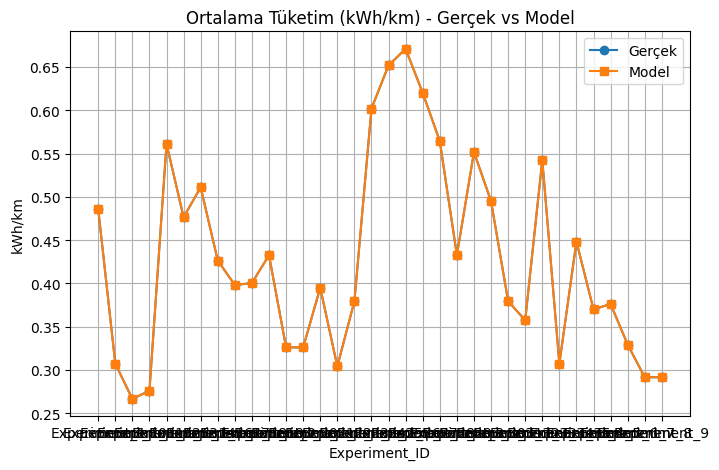

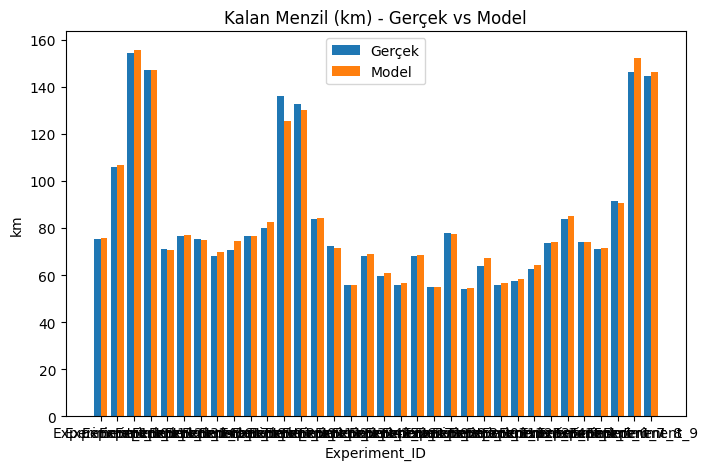

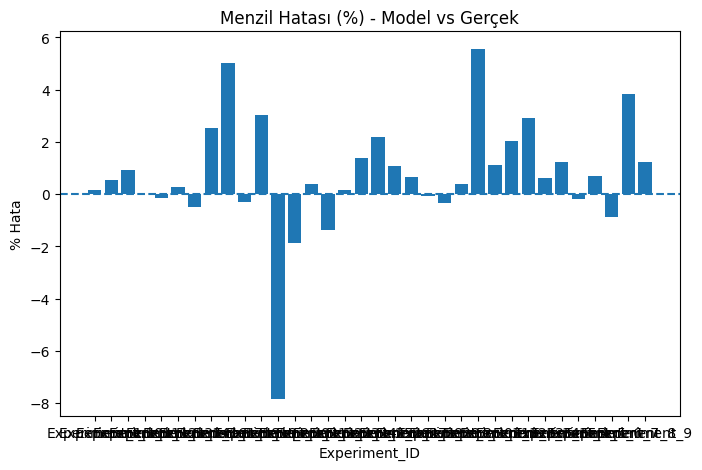

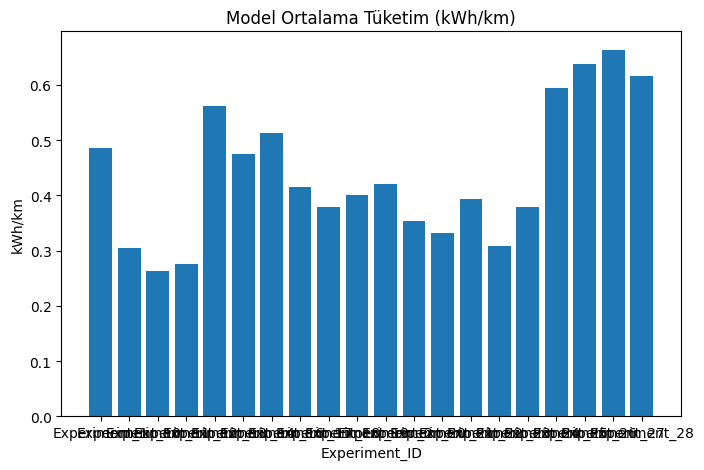

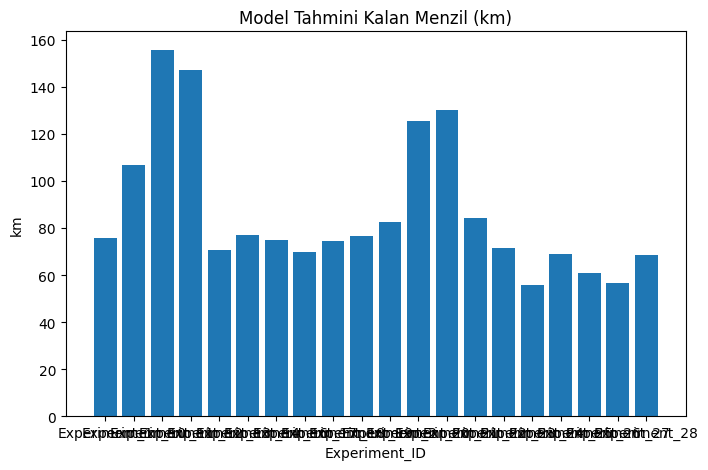

In [14]:
plot_avg_consumption(compare_df)
plot_remaining_range(compare_df)
plot_range_error_percent(compare_df)

plot_exp_summary(exp_remaining_df, top_k=20)

## 12-Faktörlerin Etkisi

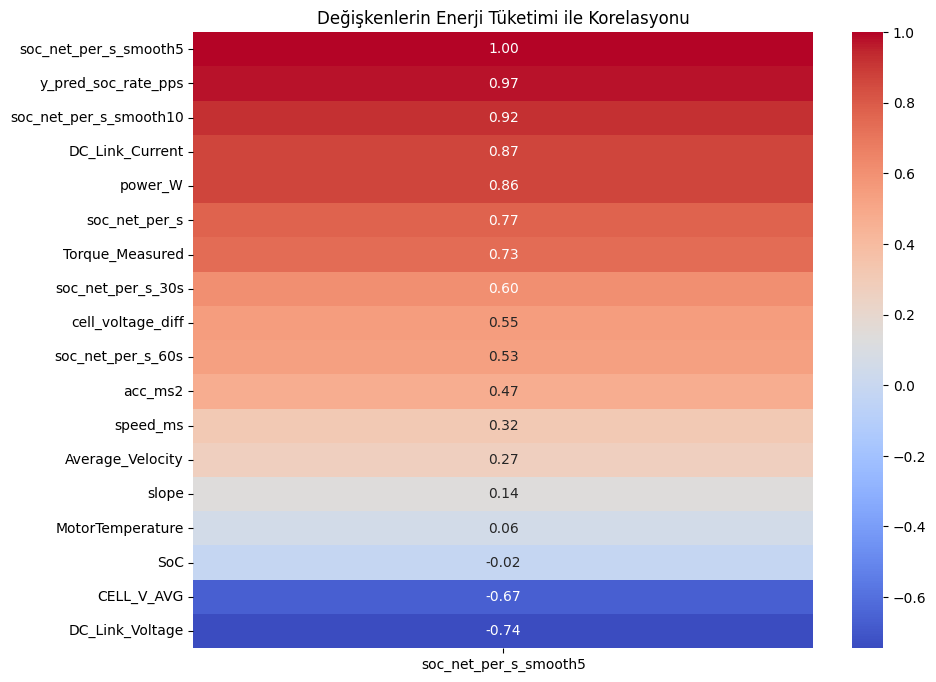

In [15]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr[['soc_net_per_s_smooth5']].sort_values(by='soc_net_per_s_smooth5', ascending=False),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Değişkenlerin Enerji Tüketimi ile Korelasyonu")
plt.show()

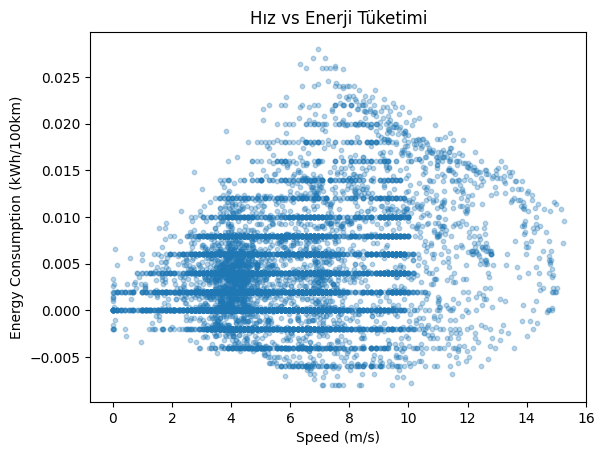

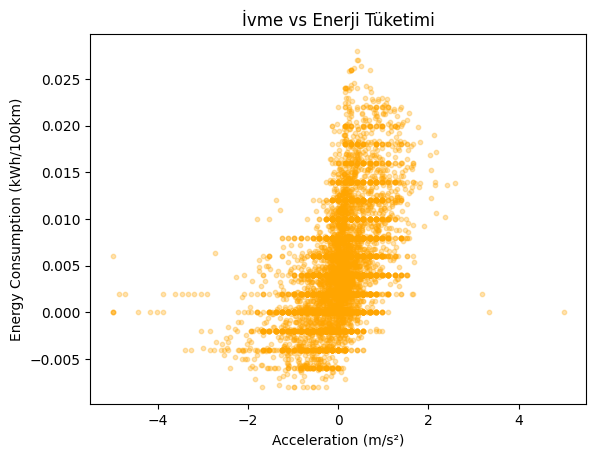

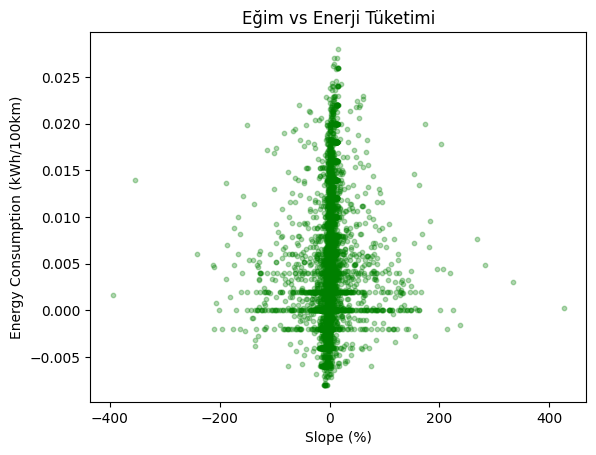

In [16]:
# Hız ve Tüketim
plt.scatter(df["speed_ms"], df["soc_net_per_s_smooth5"], alpha=0.3, s=10)
plt.xlabel("Speed (m/s)")
plt.ylabel("Energy Consumption (kWh/100km)")
plt.title("Hız vs Enerji Tüketimi")
plt.show()

# İvme ve Tüketim
plt.scatter(df["acc_ms2"], df["soc_net_per_s_smooth5"], alpha=0.3, s=10, color="orange")
plt.xlabel("Acceleration (m/s²)")
plt.ylabel("Energy Consumption (kWh/100km)")
plt.title("İvme vs Enerji Tüketimi")
plt.show()

# Eğim ve Tüketim
plt.scatter(df["slope"], df["soc_net_per_s_smooth5"], alpha=0.3, s=10, color="green")
plt.xlabel("Slope (%)")
plt.ylabel("Energy Consumption (kWh/100km)")
plt.title("Eğim vs Enerji Tüketimi")
plt.show()